In [1]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
from IPython.display import HTML
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from scipy.signal import hamming
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

%matplotlib inline
%reload_ext tensorboard
import cv2
import pandas as pd

In [2]:
import tensorboard
import tensorflow as tf
from datetime import datetime
from packaging import version
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  0
Num CPUs Available:  1


## Выгрузка

Здесь приводим интерполяцией изображения к формату 96x96, интерполируем временной ряд каждого пикселя, чтобы получить на всём временном промежутке 192 кадра, сглаживаем билатеральной фильтрацией

Before filtering
Before filtering
Before filtering
Before filtering
Before filtering
Before filtering


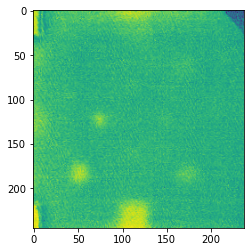

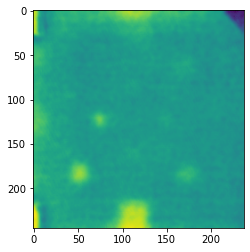

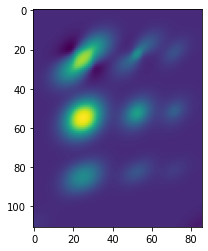

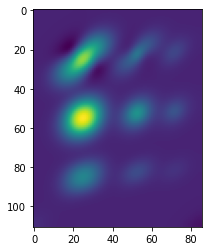

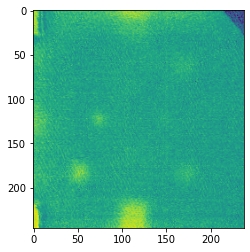

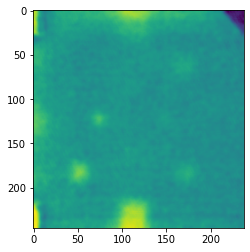

In [3]:
image_data = []
IM_SIZE = 96
TIME_SIZE = 192
FREQ_SIZE = TIME_SIZE//2-1

folder_names = ["01", "02", "03"]

for folder_name in folder_names:
    
    directory = "C:\\Users\\Ivan\\JupyterProjects\\Task 4\\"+folder_name
    series = []
    
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            series.append(np.fromfile(f, dtype='uint32').reshape(int(filename.split("x")[0]),-1))
    series = np.array(series, dtype='float32')[20:,...]
    x = np.transpose((series-np.min(series))/(np.max(series)-np.min(series)), (1,2,0))
    x = x**0.25
    
    print("Before filtering")
    plt.figure()
    plt.imshow(x[:,:,-10])
    
    for i in range(x.shape[2]):
        x[:,:,i] = cv2.bilateralFilter(x[:,:,i],7,70,70)
    
    print("Before filtering")
    plt.figure()
    plt.imshow(x[:,:,-10])
    
    x_reshaped = np.transpose(tf.keras.preprocessing.image.smart_resize(x, (IM_SIZE,IM_SIZE), interpolation='bilinear'), (2,0,1))
    
    time_ax = np.linspace(0,1,x_reshaped.shape[0])
    new_time_ax = np.linspace(0,1,TIME_SIZE)
    f_interp = interp1d(time_ax,x_reshaped, axis=0)
    x_time_reshaped = f_interp(new_time_ax)[...,np.newaxis]
    
    image_data.append((x_time_reshaped-np.mean(x_time_reshaped))/np.std(x_time_reshaped))

image_data = np.array(image_data)

## Фурье от временных рядов

In [4]:
fourier_data = []

for item in image_data:
    fourier_series = np.zeros((item.shape[0]//2-1, item.shape[1], item.shape[2]))
    
    for i in range(item.shape[1]):
        for j in range(item.shape[2]):            
            y = item[:, i, j, 0]
            
            N = len(y)
            T = 1.0
            w = hamming(N)
            
            ywf = fft(y*w)[1:N//2]
            fourier_series[:, i, j] = np.log(2.0/N * np.abs(ywf))
    fourier_series = fourier_series[10:] 
    fourier_series = (fourier_series - np.mean(fourier_series))/np.std(fourier_series)
    fourier_data.append(fourier_series)
    
fourier_data = np.expand_dims(np.array(fourier_data),axis=4)

time_fourier_data = np.transpose(fourier_data.reshape(fourier_data.shape[0], fourier_data.shape[1],-1), (0,2,1))[...,np.newaxis]
time_fourier_data.shape

(3, 9216, 85, 1)

In [5]:
freq_ax = np.linspace(0,1,time_fourier_data.shape[2])
new_freq_ax = np.linspace(0,1,FREQ_SIZE+1)
f_interp = interp1d(freq_ax,time_fourier_data, axis=2)
time_fourier_data = f_interp(new_freq_ax)
time_fourier_data.shape

(3, 9216, 96, 1)

Теперь можно добавить данные к временным, предварительно прогнав через CNN и LSTM (не пробовал)

## Анимация для красоты

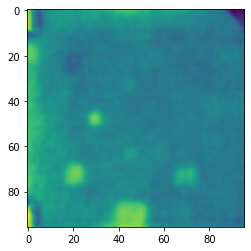

In [6]:
fig, ax = plt.subplots()
im=plt.imshow(image_data[0][0,:,:],interpolation='none')

# animation function.  This is called sequentially
def animate(i):
    ax.imshow(image_data[0][i+60,:,:])
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=30, interval=50, blit=True)


HTML(anim.to_html5_video()) 

# f = "C:\\Users\\Ivan\\JupyterProjects\\Task 4\\animation.gif" 
# writergif = animation.PillowWriter(fps=20) 
# anim.save(f, writer=writergif, dpi=50)

# Сохранение/подгрузка данных

In [7]:
# np.save('pics.npy', image_data)
# image_data = np.load('pics.npy')
image_data.shape

(3, 192, 96, 96, 1)

In [8]:
time_data = np.transpose(image_data.reshape(image_data.shape[0], image_data.shape[1],-1), (0,2,1))[...,np.newaxis]
time_data.shape

(3, 9216, 192, 1)

## Предобучение

In [9]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from keras import backend as K

In [10]:
tr_time_data = time_data[0]
tr_image_data = image_data[0]
tr_freq_data = time_fourier_data[0]

In [11]:
print(tr_time_data.shape)
print(tr_image_data.shape)
print(tr_freq_data.shape)

(9216, 192, 1)
(192, 96, 96, 1)
(9216, 96, 1)


In [12]:
keras.backend.clear_session()
FIRST_CONV = 64
ALL_CONV = 2
SHRINK_SIZE = 8
LOW_LSTM = 3
HIGH_LSTM = 96
inputs = keras.Input(shape=(TIME_SIZE, 1), name="input_layer")


enc = layers.Conv1D(FIRST_CONV, kernel_size=SHRINK_SIZE, strides=1, padding='same', activation=layers.LeakyReLU())(inputs)
enc = layers.MaxPool1D(pool_size=SHRINK_SIZE)(enc)
enc = layers.Conv1D(FIRST_CONV*2, kernel_size=SHRINK_SIZE, strides=1, padding='same', activation=layers.LeakyReLU())(enc)
enc = layers.MaxPool1D(pool_size=SHRINK_SIZE)(enc)

enc = layers.Bidirectional(layers.LSTM(HIGH_LSTM, return_sequences=True), merge_mode='sum')(enc)
enc = layers.LeakyReLU()(enc)
enc = layers.Bidirectional(layers.LSTM(LOW_LSTM, return_sequences=True), merge_mode='sum')(enc)
enc = layers.LeakyReLU()(enc)

enc = layers.Flatten(name="repr_layer")(enc)
# enc = layers.Dense(units=TIME_SIZE//(2**ALL_CONV))(enc)
# enc = layers.Dense(6)(enc)
# dec = layers.Dense(units=TIME_SIZE//(2**ALL_CONV))(enc)

dec = layers.Reshape(target_shape=[-1,LOW_LSTM])(enc)

dec = layers.Bidirectional(layers.LSTM(LOW_LSTM, return_sequences=True), merge_mode='sum')(dec)
dec = layers.LeakyReLU()(dec)
dec = layers.Bidirectional(layers.LSTM(HIGH_LSTM, return_sequences=True), merge_mode='sum')(dec)
dec = layers.LeakyReLU()(dec)

dec = layers.TimeDistributed(layers.Dense(units=FIRST_CONV*(2**(ALL_CONV-1))))(dec)
dec = layers.LeakyReLU()(dec)

dec = layers.UpSampling1D(size=SHRINK_SIZE)(dec)
dec = layers.Conv1DTranspose(FIRST_CONV*2, kernel_size=SHRINK_SIZE, strides=1, padding='same')(dec)
dec = layers.UpSampling1D(size=SHRINK_SIZE)(dec)
dec = layers.Conv1DTranspose(FIRST_CONV, kernel_size=SHRINK_SIZE, strides=1, padding='same')(dec)
output = layers.Conv1DTranspose(1, kernel_size=SHRINK_SIZE, strides=1, padding='same', name="dec_output")(dec)

pretrain_model = keras.Model(inputs=inputs, outputs=[output], name="pretrain_model")
pretrain_model.summary()

Model: "pretrain_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 192, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 192, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 128)           65664     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 3, 96)         

In [13]:
pretrain_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss={"dec_output":"mse"})

In [14]:
pretrain_history = pretrain_model.fit(
    [tr_time_data],
    [tr_time_data],
    epochs=150,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
)

Epoch 1/150
65/65 [==============================] - 15s 104ms/step - loss: 0.1973 - val_loss: 0.0690
Epoch 2/150
65/65 [==============================] - 5s 74ms/step - loss: 0.0253 - val_loss: 0.0570
Epoch 3/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0167 - val_loss: 0.0290
Epoch 4/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0085 - val_loss: 0.0158
Epoch 5/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 6/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0058 - val_loss: 0.0105
Epoch 7/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0050 - val_loss: 0.0091
Epoch 8/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0044 - val_loss: 0.0139
Epoch 9/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0045 - val_loss: 0.0074
Epoch 10/150
65/65 [==============================] - 5s 73ms/step - loss: 0.0042 - val_loss: 0.01

65/65 [==============================] - 5s 76ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 83/150
65/65 [==============================] - 5s 78ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 84/150
65/65 [==============================] - 5s 76ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 85/150
65/65 [==============================] - 5s 75ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 86/150
65/65 [==============================] - 5s 76ms/step - loss: 0.0021 - val_loss: 0.0033


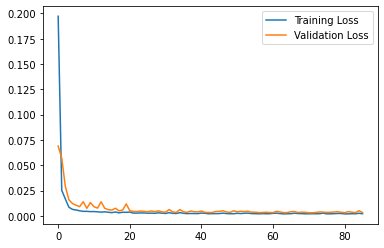

In [15]:
plt.plot(pretrain_history.history["loss"], label="Training Loss")
plt.plot(pretrain_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

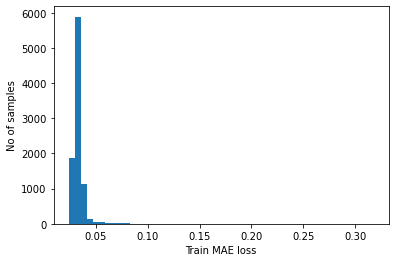

Reconstruction error threshold:  0.11963718956611623


In [16]:
pred_time_data = pretrain_model.predict(tr_time_data)
train_mae_loss = np.mean(np.abs(pred_time_data - tr_time_data), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


threshold = np.percentile(train_mae_loss, 99.9)
print("Reconstruction error threshold: ", threshold)

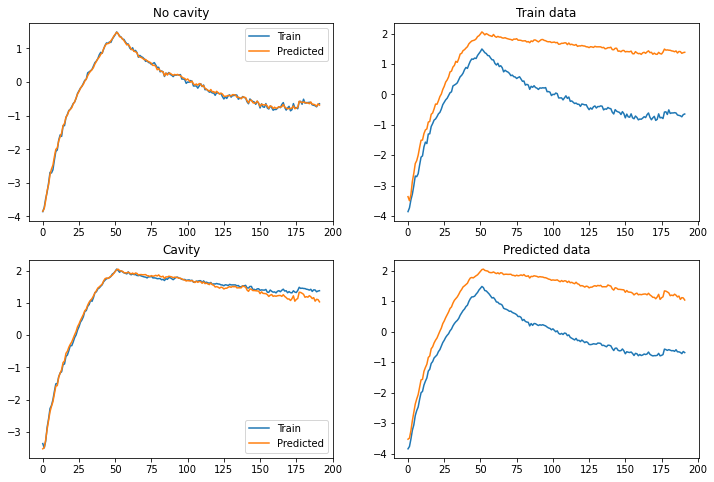

In [17]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].plot(tr_time_data[IM_SIZE*45+45],label="ss")
ax[0,0].plot(pred_time_data[IM_SIZE*45+45])
ax[0,0].title.set_text('No cavity')
ax[0,0].legend(["Train","Predicted"])

ax[1,0].plot(tr_time_data[IM_SIZE*90+45])
ax[1,0].plot(pred_time_data[IM_SIZE*90+45])
ax[1,0].title.set_text('Cavity')
ax[1,0].legend(["Train","Predicted"])

ax[0,1].plot(tr_time_data[IM_SIZE*45+45])
ax[0,1].plot(tr_time_data[IM_SIZE*90+45])
ax[0,1].title.set_text('Train data')

ax[1,1].plot(pred_time_data[IM_SIZE*45+45])
ax[1,1].plot(pred_time_data[IM_SIZE*90+45])
ax[1,1].title.set_text('Predicted data')

Сохраняем, чтобы затем для каждой кластеризации заново загружать (обучение с одной кластеризацией не должно влиять на веса при обучении с другой кластеризацией)

In [18]:
pretrain_model.save('model.h5')

# CID

Функция для вычисления CID расстояния для попарных расстояний временных рядов из двух наборов inputs1 и inputs2. Она же реализована в классе ClusteringLayer, чтобы считать расстояния от центроид до латентных временных рядов.

In [19]:
def cid_matrix(inputs1, inputs2):
        
        t1 = tf.cast(tf.reshape(inputs1, (1,-1,*inputs1.shape[1:])), dtype='float32')
        t2 = tf.cast(tf.reshape(inputs2, (-1,1,*inputs2.shape[1:])), dtype='float32')
        
        euc = tf.norm(t1-t2, ord='euclidean', axis=2)

        compl_est1 = tf.sqrt(tf.reduce_sum(tf.square(inputs1[:,1:]-inputs1[:,:-1]), axis=1))
        compl_est2 = tf.sqrt(tf.reduce_sum(tf.square(inputs2[:,1:]-inputs2[:,:-1]), axis=1))
        
        c1 = tf.reshape(compl_est1, (1,-1))
        c2 = tf.reshape(compl_est2, (-1,1))

        compl_fac = tf.divide(tf.maximum(c1,c2),tf.minimum(c1,c2))
        cid = tf.multiply(euc, compl_fac)
        
        return cid

Игрушечный пример для кластеризации по CID. Работает не всегда

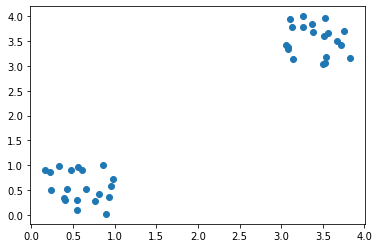

In [20]:
cl1 = np.random.randint(1,1000,(20,2))/1000
cl2 = np.random.randint(3000,4000,(20,2))/1000
cl = np.vstack([cl1, cl2])
cl = np.array(cl, dtype=np.float32)
cid = cid_matrix(cl, cl)
plt.scatter(cl[:,0], cl[:,1])

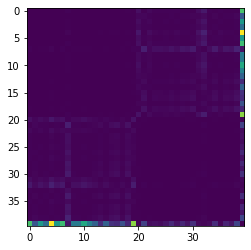

In [21]:
plt.imshow(cid.numpy())

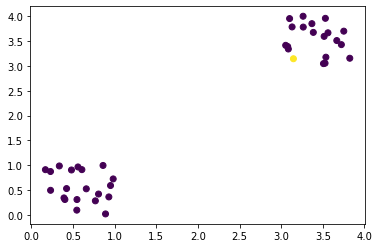

In [22]:
toy_labels = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage='complete').fit_predict(cid.numpy())
plt.scatter(cl[:,0], cl[:,1], c=toy_labels)

# Инициализация кластеров

In [24]:
repr_model = keras.Model(inputs=pretrain_model.get_layer("input_layer").input, outputs=pretrain_model.get_layer("repr_layer").output, name="repr_model")
repr_time_data = repr_model.predict(tr_time_data)
repr_time_data.shape

(9216, 9)

In [25]:
dd = TSNE(n_components=2, verbose=1, random_state=13).fit_transform(repr_time_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9216 samples in 0.009s...
[t-SNE] Computed neighbors for 9216 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9216
[t-SNE] Computed conditional probabilities for sample 2000 / 9216
[t-SNE] Computed conditional probabilities for sample 3000 / 9216
[t-SNE] Computed conditional probabilities for sample 4000 / 9216
[t-SNE] Computed conditional probabilities for sample 5000 / 9216
[t-SNE] Computed conditional probabilities for sample 6000 / 9216
[t-SNE] Computed conditional probabilities for sample 7000 / 9216
[t-SNE] Computed conditional probabilities for sample 8000 / 9216
[t-SNE] Computed conditional probabilities for sample 9000 / 9216
[t-SNE] Computed conditional probabilities for sample 9216 / 9216
[t-SNE] Mean sigma: 0.020464
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.287895
[t-SNE] KL divergence after 1000 iterations: 1.093539


Важно! Здесь задаётся число кластеров. Дальнейшее обучение крайне чувствительно к выбору количества центроид

In [26]:
n_clusters = 4

Инициализируем центроиды

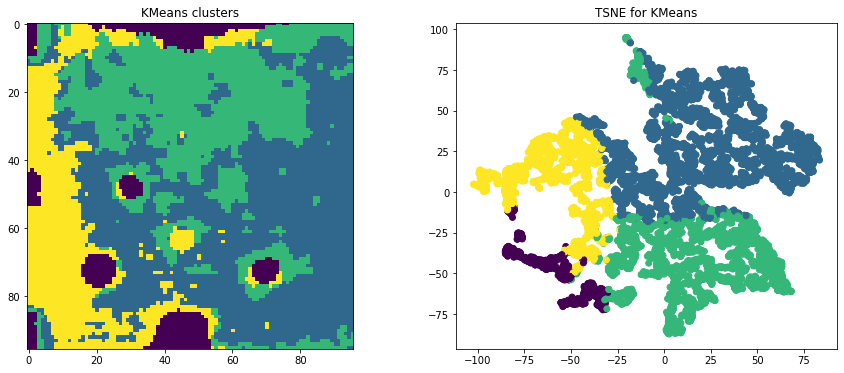

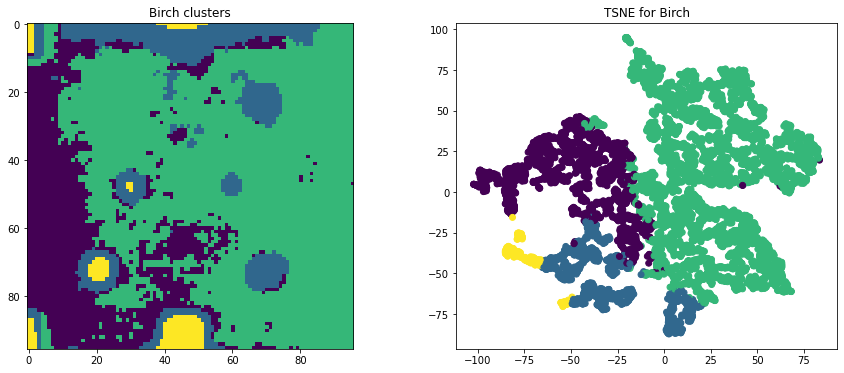

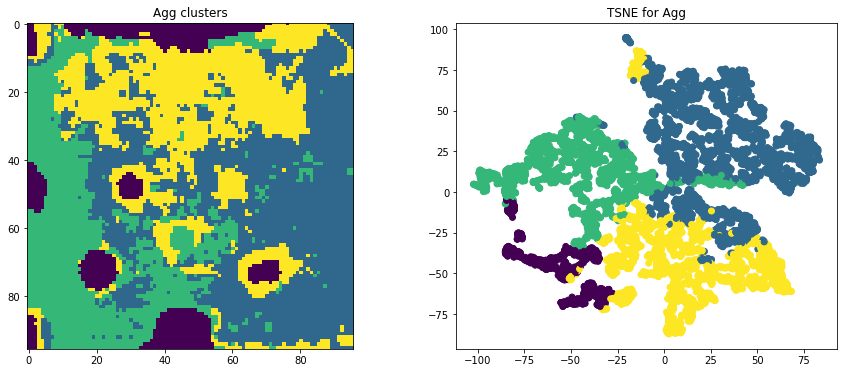

In [27]:
cluster_models = {"KMeans":KMeans(n_clusters=n_clusters, n_init=50), 
                      "Birch":Birch(n_clusters=n_clusters, threshold=0.01, branching_factor=50), 
                      "Agg":AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage='ward')}

start_labels = {}
centroid_models = {}
for cluster_type in cluster_models:
    start_labels[cluster_type] = cluster_models[cluster_type].fit_predict(repr_time_data)
    centroids = []
    for i in range(n_clusters):
        centroids.append(tf.math.reduce_mean(tf.convert_to_tensor(repr_time_data[start_labels[cluster_type]==i]), axis=0))
        
    centroid_models[cluster_type] = np.array(centroids)
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    ax[0].imshow(start_labels[cluster_type].reshape(IM_SIZE, IM_SIZE))
    ax[0].title.set_text(f"{cluster_type} clusters")

    ax[1].scatter(dd[:,0], dd[:,1], c=start_labels[cluster_type])
    ax[1].title.set_text(f"TSNE for {cluster_type}")
    
    plt.show()

# Картинки

KMeans, pretrained, silhouette_score - 0.3376377522945404


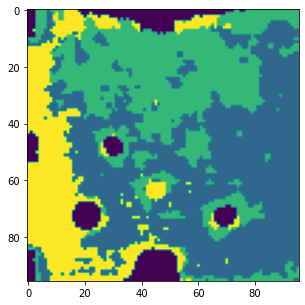

Birch, pretrained, silhouette_score - 0.38372084498405457


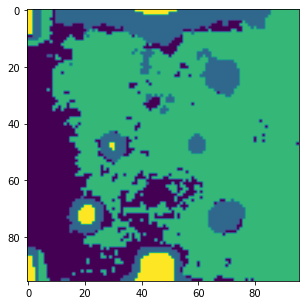

Agg, pretrained, silhouette_score - 0.3019081652164459


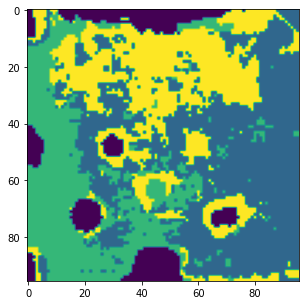

In [30]:
for cluster_type in start_labels:
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    print(f"{cluster_type}, pretrained, silhouette_score - {silhouette_score(repr_time_data,start_labels[cluster_type])}")
    ax.imshow(start_labels[cluster_type].reshape((IM_SIZE,IM_SIZE)))

    plt.show()

KMeans, raw, silhouette - 0.48563591260158756


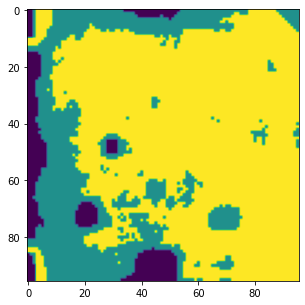

Birch, raw, silhouette - 0.4981262412469846


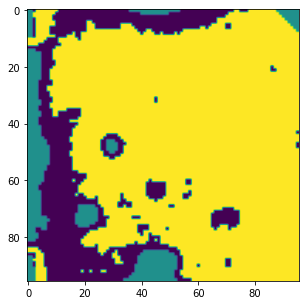

Agg, raw, silhouette - 0.4981262412469846


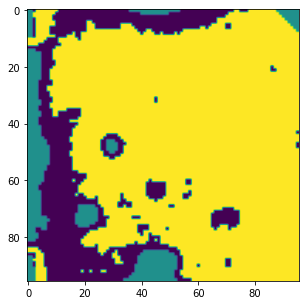

In [31]:
for cluster_type in cluster_models:
    raw_labels = cluster_models[cluster_type].fit_predict(tr_time_data[:,:,0])
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    print(f"{cluster_type}, raw, silhouette - {silhouette_score(tr_time_data[:,:,0],raw_labels)}")
    ax.imshow(((raw_labels+1)%3).reshape((IM_SIZE,IM_SIZE)))

    plt.show()

Слой кластеризации на основе Keras.layers.Layer. Важно: входные данные батч одномерных временных рядов размеров (batch)x(timesteps)

In [32]:
class ClusteringLayer(layers.Layer):
    
    
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.initial_weights = weights
        self.n_clusters = n_clusters
        self.input_spec = layers.InputSpec(ndim=2)

        
    def build(self, input_shape):
        
#         print(input_shape)
        assert len(input_shape) == 2
        feature_num = input_shape[1]
        self.input_spec = layers.InputSpec(dtype=K.floatx(), shape=(None,feature_num))
        
        cluster_init = tf.zeros_initializer()
        self.clusters = self.add_weight(shape=(self.n_clusters, feature_num), initializer='glorot_uniform', name='clusters', trainable=True)

        if self.initial_weights is not None:
            self.set_weights([self.initial_weights])
            del self.initial_weights
        self.built = True
        

    def _cid_matrix(self, inputs1, inputs2):
        
        t1 = tf.cast(tf.reshape(inputs1, (1,-1,inputs1.shape[1])), dtype='float32')
        t2 = tf.cast(tf.reshape(inputs2, (-1,1,inputs2.shape[1])), dtype='float32')
        
        euc = tf.norm(t1-t2, ord='euclidean', axis=2)
        compl_est1 = tf.sqrt(tf.reduce_sum(tf.square(inputs1[:,1:]-inputs1[:,:-1]), axis=1))
        compl_est2 = tf.sqrt(tf.reduce_sum(tf.square(inputs2[:,1:]-inputs2[:,:-1]), axis=1))
        
        c1 = tf.reshape(compl_est1, (1,-1))
        c2 = tf.reshape(compl_est2, (-1,1))

        compl_fac = tf.divide(tf.maximum(c1,c2),tf.minimum(c1,c2))
        cid = tf.multiply(euc, compl_fac)
        
        return cid

    
    def call(self, inputs, **kwargs):
        
        distances = self._cid_matrix(self.clusters, inputs)
        temp1 = tf.reduce_sum(tf.divide(tf.ones(1), tf.add(tf.ones(1), distances)), axis=1)
        q = tf.multiply(tf.divide(tf.ones(1), tf.add(tf.ones(1), distances)), tf.expand_dims(temp1,1))
        return q

    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 3
        return input_shape[1], self.n_clusters

    
    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Здесь создаётся кастомная Loss функция на основе Keras.losses.Loss. В ней считается распределение Pij (см.статью) и оптимизируется KL Divergence

In [33]:
class ClusterLoss(losses.Loss):
    def __init__(self):
        super(ClusterLoss, self).__init__()
        self.kl = losses.KLDivergence()
    
    def call(self, y_true, y_pred, sample_weight=None):
        temp = tf.expand_dims(tf.reduce_sum(y_pred, axis=0), axis=0)
        p = tf.stop_gradient(tf.divide(tf.divide(tf.square(y_pred), temp), tf.expand_dims(tf.reduce_sum(tf.divide(tf.square(y_pred), temp), axis=1), axis=1)))
        
        return self.kl(p, y_pred, sample_weight)

Epoch 1/45
4/4 [==============================] - 15s 2s/step - loss: -0.1272 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2905 - val_loss: -0.1119 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.1516
Epoch 2/45
4/4 [==============================] - 4s 1s/step - loss: -0.1274 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2917 - val_loss: -0.1121 - val_dec_output_loss: 0.0032 - val_cluster_layer_loss: -1.1533
Epoch 3/45
4/4 [==============================] - 5s 1s/step - loss: -0.1275 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2927 - val_loss: -0.1122 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.1549
Epoch 4/45
4/4 [==============================] - 4s 1s/step - loss: -0.1276 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2936 - val_loss: -0.1125 - val_dec_output_loss: 0.0032 - val_cluster_layer_loss: -1.1567
Epoch 5/45
4/4 [==============================] - 4s 1s/step - loss: -0.1277 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.294

4/4 [==============================] - 4s 993ms/step - loss: -0.1300 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3186 - val_loss: -0.1186 - val_dec_output_loss: 0.0027 - val_cluster_layer_loss: -1.2127
Epoch 39/45
4/4 [==============================] - 4s 993ms/step - loss: -0.1301 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3192 - val_loss: -0.1187 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2139
Epoch 40/45
4/4 [==============================] - 4s 994ms/step - loss: -0.1301 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3197 - val_loss: -0.1189 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2151
Epoch 41/45
4/4 [==============================] - 4s 993ms/step - loss: -0.1302 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3202 - val_loss: -0.1190 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2164
Epoch 42/45
4/4 [==============================] - 4s 992ms/step - loss: -0.1302 - dec_output_loss: 0.0018 - cluster_layer_loss:

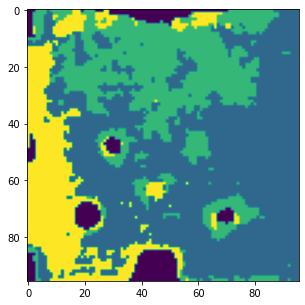

Epoch 1/45
4/4 [==============================] - 16s 2s/step - loss: -0.1185 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2030 - val_loss: -0.1057 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.0892
Epoch 2/45
4/4 [==============================] - 4s 1s/step - loss: -0.1186 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2041 - val_loss: -0.1058 - val_dec_output_loss: 0.0032 - val_cluster_layer_loss: -1.0901
Epoch 3/45
4/4 [==============================] - 4s 1s/step - loss: -0.1187 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2053 - val_loss: -0.1058 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.0910
Epoch 4/45
4/4 [==============================] - 5s 1s/step - loss: -0.1188 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2065 - val_loss: -0.1059 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.0918
Epoch 5/45
4/4 [==============================] - 5s 1s/step - loss: -0.1190 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.207

Epoch 39/45
4/4 [==============================] - 5s 1s/step - loss: -0.1225 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2436 - val_loss: -0.1089 - val_dec_output_loss: 0.0034 - val_cluster_layer_loss: -1.1231
Epoch 40/45
4/4 [==============================] - 5s 1s/step - loss: -0.1226 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2445 - val_loss: -0.1090 - val_dec_output_loss: 0.0034 - val_cluster_layer_loss: -1.1240
Epoch 41/45
4/4 [==============================] - 6s 1s/step - loss: -0.1227 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2454 - val_loss: -0.1091 - val_dec_output_loss: 0.0034 - val_cluster_layer_loss: -1.1250
Epoch 42/45
4/4 [==============================] - 5s 1s/step - loss: -0.1228 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.2463 - val_loss: -0.1092 - val_dec_output_loss: 0.0034 - val_cluster_layer_loss: -1.1259
Epoch 43/45
4/4 [==============================] - 6s 1s/step - loss: -0.1229 - dec_output_loss: 0.0018 - cluster_layer_loss: -1

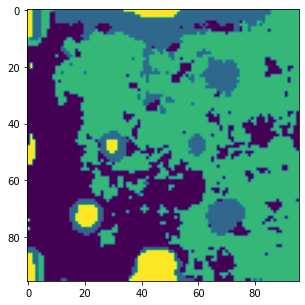

Epoch 1/45
4/4 [==============================] - 19s 3s/step - loss: -0.1282 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3003 - val_loss: -0.1114 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.1468
Epoch 2/45
4/4 [==============================] - 8s 2s/step - loss: -0.1283 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3012 - val_loss: -0.1116 - val_dec_output_loss: 0.0032 - val_cluster_layer_loss: -1.1486
Epoch 3/45
4/4 [==============================] - 8s 2s/step - loss: -0.1284 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3019 - val_loss: -0.1118 - val_dec_output_loss: 0.0033 - val_cluster_layer_loss: -1.1504
Epoch 4/45
4/4 [==============================] - 9s 2s/step - loss: -0.1285 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3027 - val_loss: -0.1121 - val_dec_output_loss: 0.0032 - val_cluster_layer_loss: -1.1524
Epoch 5/45
4/4 [==============================] - 9s 2s/step - loss: -0.1286 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.303

Epoch 39/45
4/4 [==============================] - 8s 2s/step - loss: -0.1309 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3269 - val_loss: -0.1193 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2191
Epoch 40/45
4/4 [==============================] - 9s 2s/step - loss: -0.1309 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3275 - val_loss: -0.1195 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2206
Epoch 41/45
4/4 [==============================] - 8s 2s/step - loss: -0.1310 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3280 - val_loss: -0.1196 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2221
Epoch 42/45
4/4 [==============================] - 8s 2s/step - loss: -0.1310 - dec_output_loss: 0.0018 - cluster_layer_loss: -1.3285 - val_loss: -0.1198 - val_dec_output_loss: 0.0026 - val_cluster_layer_loss: -1.2235
Epoch 43/45
4/4 [==============================] - 8s 2s/step - loss: -0.1311 - dec_output_loss: 0.0018 - cluster_layer_loss: -1

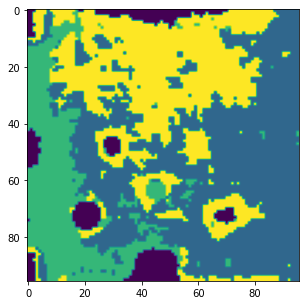

In [35]:
final_labels = {}
final_scores = {}

for cluster_type in centroid_models:
    pretrain_model = keras.models.load_model('model.h5')

    
    all_layers = [l for l in pretrain_model.layers]
    x = all_layers[0].output
    for i in range(1, len(all_layers)):
        x = all_layers[i](x)
        if all_layers[i].name == "repr_layer":
            clayer = ClusteringLayer(n_clusters=n_clusters, weights=centroid_models[cluster_type], name='cluster_layer')(x)
    cluster_model = keras.Model(inputs=all_layers[0].input, outputs=[x, clayer], name="cluster_model")

    cluster_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
                          loss={'cluster_layer':ClusterLoss(), "dec_output":"mse"},
                          loss_weights={'cluster_layer':0.1, "dec_output":1})

    cluster_history = cluster_model.fit(
        tr_time_data,
        tr_time_data,
        batch_size=IM_SIZE*IM_SIZE//4,
        epochs=45,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, mode="min")
        ],
    )

    final_model = keras.Model(inputs=cluster_model.get_layer("input_layer").input, outputs=cluster_model.get_layer("cluster_layer").output, name="final_model") 
    q = final_model.predict(tr_time_data)
    labels = tf.argmax(q, axis=1).numpy()


    repr_model = keras.Model(inputs=cluster_model.get_layer("input_layer").input, outputs=cluster_model.get_layer("repr_layer").output, name="score_repr_model")
    score_repr = repr_model.predict(tr_time_data)

    final_labels[cluster_type] = labels
    final_scores[cluster_type] = silhouette_score(score_repr, labels)

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    print(f"{cluster_type}, trained, silhouette - {final_scores[cluster_type]}")
    ax.imshow(labels.reshape((IM_SIZE,IM_SIZE)))

    plt.show()

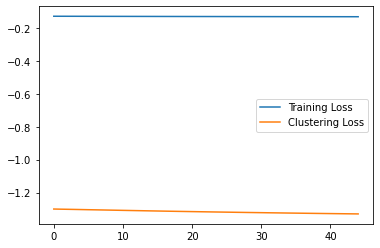

In [36]:
plt.plot(cluster_history.history["loss"], label="Training Loss")
plt.plot(cluster_history.history['cluster_layer_loss'], label="Clustering Loss")
plt.legend()
plt.show()

KMeans, trained, silhouette - 0.3423047959804535


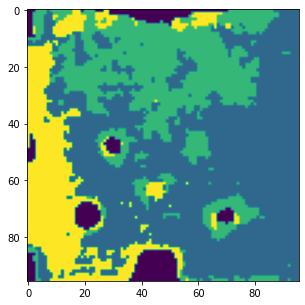

Birch, trained, silhouette - 0.3360951542854309


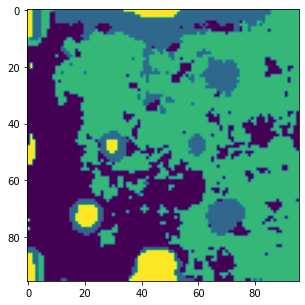

Agg, trained, silhouette - 0.3368860185146332


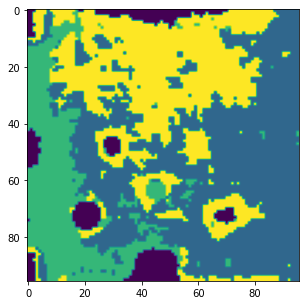

In [37]:
for cluster_type in final_labels:
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    print(f"{cluster_type}, trained, silhouette - {final_scores[cluster_type]}")
    ax.imshow(final_labels[cluster_type].reshape((IM_SIZE,IM_SIZE)))

    plt.show()